In [26]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import dtale
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [27]:
data = pd.read_csv('./data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [28]:
print(data.shape)
# (1338, 7)

(1338, 7)


In [29]:
# Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [30]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [31]:
d = dtale.show(data)
d

In [32]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply( lambda x: 0 if x=='no' else 1)
data['sex'] = data['sex'].apply( lambda x: 0 if x=='female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)

data.head()
features = data.drop('charges', axis=1).columns
X,y = data[features], data['charges']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)
 

Train: (1070, 9) (1070,)
Test: (268, 9) (268,)


In [46]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)
print("Train R^2: {:.4f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.4f}".format(metrics.r2_score(y_test, y_test_predict)))
print("Train MAE: {:.4f}".format(metrics.mean_absolute_error(y_train, y_train_predict)))
print("Test MAE: {:.4f}".format(metrics.mean_absolute_error(y_test, y_test_predict)))
print("Train MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
print("Test MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
print(lr_model.intercept_)

Train R^2: 0.7417
Test R^2: 0.7836
Train MAE: 4208.2346
Test MAE: 4181.1945
Train MAPE: 42.203
Test MAPE: 46.888
-12390.804294570278


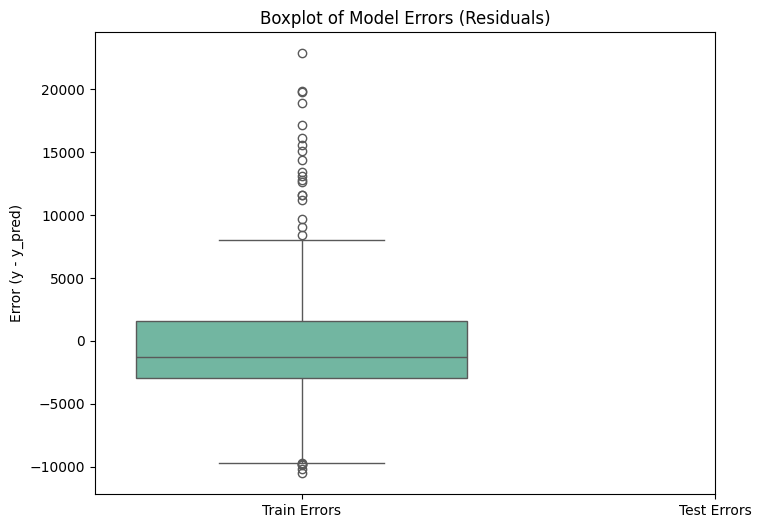

In [48]:

# Calculate residuals (errors)
train_errors = y_train - y_train_predict
test_errors = y_test - y_test_predict

# Create boxplot of errors
plt.figure(figsize=(8, 6))
sns.boxplot(data=[train_errors, test_errors], palette="Set2")
plt.xticks([0, 1], ['Train Errors', 'Test Errors'])
plt.title('Boxplot of Model Errors (Residuals)')
plt.ylabel('Error (y - y_pred)')
plt.show()

In [49]:
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.MinMaxScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
#Производим normalize тренировочной выборки
X_train_scaled = scaler.transform(X_train)
#Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(1070, 54)
(268, 54)


In [50]:
# Обучите модель линейной регрессии на полиномиальных признаках.
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled_poly, y_train)
y_train_predict = lr_model.predict(X_train_scaled_poly)
y_test_predict = lr_model.predict(X_test_scaled_poly)
print("Train R^2: {:.4f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.4f}".format(metrics.r2_score(y_test, y_test_predict)))
print("Train MAE: {:.4f}".format(metrics.mean_absolute_error(y_train, y_train_predict)))
print("Test MAE: {:.4f}".format(metrics.mean_absolute_error(y_test, y_test_predict)))
print("Train MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
print("Test MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
print(lr_model.intercept_)

Train R^2: 0.8417
Test R^2: 0.8662
Train MAE: 2912.0137
Test MAE: 2755.7683
Train MAPE: 29.398
Test MAPE: 30.333
1.715068454483469e+16


In [51]:
# Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.
#Создаём объект класса линейной регрессии с L1-регуляризацией

lasso_lr_poly =linear_model.Lasso(max_iter=2000)
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_polly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_polly = lasso_lr_poly.predict(X_test_scaled_poly)

print("Train R^2: {:.4f}".format(metrics.r2_score(y_train, y_train_predict_polly)))
print("Test R^2: {:.4f}".format(metrics.r2_score(y_test, y_test_predict_polly)))
print("Train MAE: {:.4f}".format(metrics.mean_absolute_error(y_train, y_train_predict_polly)))
print("Test MAE: {:.4f}".format(metrics.mean_absolute_error(y_test, y_test_predict_polly)))
print("Train MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_train, y_train_predict_polly)*100))
print("Test MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_test, y_test_predict_polly)*100))

Train R^2: 0.8418
Test R^2: 0.8668
Train MAE: 2890.4733
Test MAE: 2719.3341
Train MAPE: 29.401
Test MAPE: 30.070


In [55]:
# Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly,y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
print("Train R^2: {:.4f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.4f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
print("Train MAE: {:.4f}".format(metrics.mean_absolute_error(y_train, y_train_predict_poly)))
print("Test MAE: {:.4f}".format(metrics.mean_absolute_error(y_test, y_test_predict_poly)))
print("Train MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_train, y_train_predict_poly)*100))
print("Test MAPE: {:.3f}".format(metrics.mean_absolute_percentage_error(y_test, y_test_predict_poly)*100))

Train R^2: 0.8386
Test R^2: 0.8633
Train MAE: 2948.8038
Test MAE: 2860.5545
Train MAPE: 29.546
Test MAPE: 31.380
